In [1]:
import os

import numpy as np
import random
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
%matplotlib inline

# pandas options
pd.set_option('mode.copy_on_write', True)  # pandas 2.0
pd.options.display.float_format = '{:.4f}'.format  # pd.reset_option('display.float_format')

# NumPy options
np.set_printoptions(precision = 2, suppress=True)  # suppress scientific notation

# 1. 데이터 불러오기

In [2]:
recomd = pd.read_csv('data/recommendations.csv')

In [3]:
recomd["user_id"].nunique() 

13781059

In [4]:
item_group = recomd.sort_values(by=['app_id','date'])

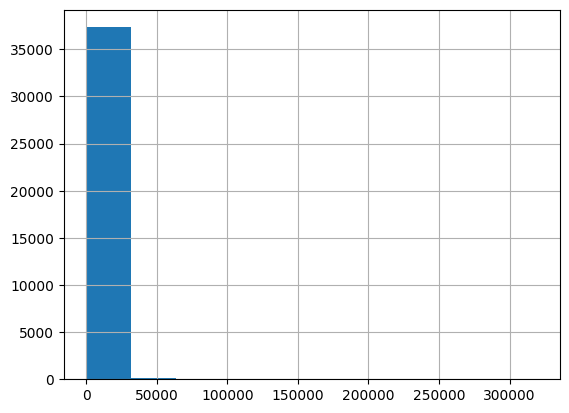

In [5]:
item_count = recomd.groupby('app_id').size().reset_index(name = 'count')
item_count['count'].hist()
plt.show()

In [6]:
# 상위 20% 아이템
threshold = item_count['count'].quantile(0.8)
print(f"임계값 (상위 20%): {threshold}")

임계값 (상위 20%): 274.0


In [7]:
# Old Items와 New Items 분리 - 상위 20% 기준으로
item_count['category'] = item_count['count'].apply(lambda x: 'Old' if x >= threshold else 'New')

old_items = item_count[item_count['category'] == 'Old']
new_items = item_count[item_count['category'] == 'New']

In [8]:
item_count['category'].value_counts()

category
New    30080
Old     7530
Name: count, dtype: int64

In [9]:
new_ids = new_items['app_id']
new_df  = item_group[item_group['app_id'].isin(new_ids)]

old_ids = old_items['app_id']
old_df = item_group[item_group['app_id'].isin(old_ids)]

In [14]:
# Grouped Data 생성
new_item_groups = new_df.groupby('app_id')

# 웜업 단계 크기 K 설정
K = 10

def split_group_safe(data, K):
    """
    데이터를 K 크기로 분리합니다.
    데이터가 부족하면 빈 DataFrame을 반환합니다.
    """
    warm_a = data.iloc[:K] if len(data) >= K else pd.DataFrame()
    warm_b = data.iloc[K:2*K] if len(data) >= 2*K else pd.DataFrame()
    warm_c = data.iloc[2*K:3*K] if len(data) >= 3*K else pd.DataFrame()
    test_set = data.iloc[3*K:] if len(data) > 3*K else pd.DataFrame()
    return warm_a, warm_b, warm_c, test_set

# 웜업 단계 분리 및 유효한 아이템 필터링
warmup_splits = {}

for item_id, item_data in tqdm(new_item_groups, desc="Processing New Items"):
    warm_a, warm_b, warm_c, test_set = split_group_safe(item_data, K)
    
    # 모든 세트에 데이터가 있는 경우에만 추가
    if all(not split.empty for split in [warm_a, warm_b, warm_c, test_set]):
        warmup_splits[item_id] = {
            'warm_a': warm_a,
            'warm_b': warm_b,
            'warm_c': warm_c,
            'test_set': test_set
        }


Processing New Items: 100%|██████████| 30080/30080 [00:15<00:00, 1889.67it/s]


In [15]:
# 단계별 데이터를 저장할 리스트
warm_a_list = []
warm_b_list = []
warm_c_list = []
test_set_list = []

# warmup_splits에서 데이터 추출
for item_id, splits in tqdm(warmup_splits.items(),desc='processing'):
    # 각 단계의 데이터를 추출하고 아이템 ID 추가
    warm_a = splits['warm_a'].copy()
    warm_a['stage'] = 'warm_a'
    warm_a_list.append(warm_a)

    warm_b = splits['warm_b'].copy()
    warm_b['stage'] = 'warm_b'
    warm_b_list.append(warm_b)

    warm_c = splits['warm_c'].copy()
    warm_c['stage'] = 'warm_c'
    warm_c_list.append(warm_c)

    test_set = splits['test_set'].copy()
    test_set['stage'] = 'test_set'
    test_set_list.append(test_set)

# 각각의 데이터프레임으로 병합
warm_a = pd.concat(warm_a_list, ignore_index=True)
warm_b = pd.concat(warm_b_list, ignore_index=True)
warm_c = pd.concat(warm_c_list, ignore_index=True)
test_set = pd.concat(test_set_list, ignore_index=True)


processing: 100%|██████████| 13249/13249 [00:17<00:00, 764.80it/s] 


In [16]:
print("Old DataFrame")
print("총 데이터 개수:", len(old_df))
print("고유 app_id 개수:", old_df['app_id'].nunique())
print("고유 user_id 개수:", old_df['user_id'].nunique())
print("-" * 40)

print("Warm A")
print("총 데이터 개수:", len(warm_a))
print("고유 app_id 개수:", warm_a['app_id'].nunique())
print("고유 user_id 개수:", warm_a['user_id'].nunique())
print("-" * 40)

print("Warm B")
print("총 데이터 개수:", len(warm_b))
print("고유 app_id 개수:", warm_b['app_id'].nunique())
print("고유 user_id 개수:", warm_b['user_id'].nunique())
print("-" * 40)

print("Warm C")
print("총 데이터 개수:", len(warm_c))
print("고유 app_id 개수:", warm_c['app_id'].nunique())
print("고유 user_id 개수:", warm_c['user_id'].nunique())
print("-" * 40)

print("Test Set")
print("총 데이터 개수:", len(test_set))
print("고유 app_id 개수:", test_set['app_id'].nunique())
print("고유 user_id 개수:", test_set['user_id'].nunique())
print("-" * 40)


Old DataFrame
총 데이터 개수: 39639864
고유 app_id 개수: 7530
고유 user_id 개수: 13670645
----------------------------------------
Warm A
총 데이터 개수: 132490
고유 app_id 개수: 13249
고유 user_id 개수: 86204
----------------------------------------
Warm B
총 데이터 개수: 132490
고유 app_id 개수: 13249
고유 user_id 개수: 93580
----------------------------------------
Warm C
총 데이터 개수: 132490
고유 app_id 개수: 13249
고유 user_id 개수: 95731
----------------------------------------
Test Set
총 데이터 개수: 894438
고유 app_id 개수: 13249
고유 user_id 개수: 500296
----------------------------------------


---